## Check GPU

Google Colab offers free GPUs, however, not all of the mare compatible with mixed precision training

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

In order to use mixed precision training we need to access to a Tesla T4

In [ ]:
!nvidia-smi -L # if not Tesla T4, don't use mix precision

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-f2ccc77e-2501-f6ee-4754-069dda256fb2)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-27 03:57:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-27 03:57:39 (110 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

Link: https://www.tensorflow.org/datasets/catalog/food101

In [ ]:
# Get TensorFlow datasets
import tensorflow_datasets as tfds

# List all available datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files = False,
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # metadata

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteAEDX6P/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteAEDX6P/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

* Class names
* The shape of our input data(image tensors)
* Datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or label encoded)
* Do the labels match up with class names?

In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image Shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}
  """) # label is not one hot encoded


  Image Shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 56,
  Class name (str form): huevos_rancheros
  


In [ ]:
# What does our image tensor look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [ ]:
# min and max of our image tensor
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from Tensorflow dataset

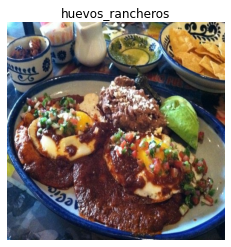

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data
Now:
* uint8 datatype
* all different size tensors (different sized images)
* Not scaled (pixel between 0 to 255)

Want:
* float32 dtype
* batches of same size
* Scaled between 0 & 1

1. Reshape our images to all the same size
2. convert the dtype of our image tensors from uint8 to float32


In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' to 'float32' and 
  reshapes image to [img_shape,img_shape, color_channels]
  """
  image = tf.image.resize(image,[img_shape, img_shape])
  # image = image/255. # not require for efficientnetb0
  return tf.cast(image, tf.float32), label

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0] # [0] to get image only not label
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape:{preprocessed_img.shape},\nDatatype:{preprocessed_img.dtype}")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[230.65816  253.64285  251.      ]
  [222.99998  254.97449  252.19388 ]
  [207.06633  255.       250.36734 ]
  ...
  [140.66287  129.52519  121.22428 ]
  [121.14268  115.265144 116.95397 ]
  [ 83.95363   83.08119   89.63737 ]]

 [[221.47449  254.37755  253.33163 ]
  [214.5102   255.       253.92348 ]
  [198.41327  254.58673  251.96939 ]
  ...
  [208.66318  195.82143  173.40823 ]
  [197.03056  190.1071   174.83162 ]
  [175.54036  171.6169   161.21384 ]]]...,
Shape:(224, 224, 3),
Datatype:<dtype: 'float32'>


## Batch & prepare datasets
https://www.tensorflow.org/guide/data_performance#best_practice_summary

In [ ]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
# prefetch = prepare new batches while the model is looking through the current batch

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Create modelling callbacks
* TensorBoard Callback
* ModelCheckpoint callback

In [ ]:
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = 'val_acc',
                                                      save_best_only=True, # save the best model which has the highest val_acc
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved)

## Setup mixed precision training

* For Tesla T4 GPU only
* Mixed Precision producing errors for TensorFlow 2.5+

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')

# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can use preprocessing layer below
# x = preprocessing.Rescaling(1/255.)

x = base_model(inputs, training=False) # make sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x) # float16
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x) # float32
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Checking layer dtype policies (are we using mixed precision?)

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)
  # layer.dtype: the datatype a layer stores its variables in
  # layer.dtype_policy: the data type policy a layer computes on its variables with

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pooling2d True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [ ]:
for layer in model.layers[1].layers[:20]: # check the layer of the base_model
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">
block2a_expand_activation False float32 <Policy "float32">


## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [ ]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15*len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name = 'training_logs',
                                                                                            experiment_name = 'efficientb0_101_classes_all_data_feature_extract'),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_feature_extract/20210925-044156
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 114s 38ms/step - loss: 1.8230 - accuracy: 0.5562 - val_loss: 1.2244 - val_accuracy: 0.6825


Epoch 2/3
2368/2368 [==============================] - 91s 38ms/step - loss: 1.2949 - accuracy: 0.6650 - val_loss: 1.1282 - val_accuracy: 0.7058


Epoch 3/3
2368/2368 [==============================] - 90s 38ms/step - loss: 1.1454 - accuracy: 0.7018 - val_loss: 1.0912 - val_accuracy: 0.7042


In [ ]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 25s 31ms/step - loss: 1.0972 - accuracy: 0.7044


[1.097172498703003, 0.7043564319610596]

## Save & Load model

### Save

In [ ]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
# model.save('/content/drive/MyDrive/personal_project/Tensorflow/feature_extraction_model_milestone_01')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/personal_project/Tensorflow/feature_extraction_model_milestone_01/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/personal_project/Tensorflow/feature_extraction_model_milestone_01/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Load

In [ ]:
# Load model previously saved above
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/personal_project/Tensorflow/feature_extraction_model_milestone_01')

In [ ]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">
block2a_expand_activation False float32 <Policy "float32">


In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_model = loaded_model.evaluate(test_data)
results_loaded_model

790/790 [==============================] - 48s 38ms/step - loss: 1.0863 - accuracy: 0.7071


[1.0863456726074219, 0.7070891261100769]

In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
np.isclose(results_loaded_model, results_feature_extract_model).all()

True

## Preparing our model's for fine-tuning

### My loaded model

In [ ]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)

# Unfreeze all of the layer in base model
loaded_model.trainable = True

In [ ]:
loaded_model.compile(loss="sparse_categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    metrics=['accuracy'])

In [ ]:
for layer in loaded_model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "float32">
global_average_pooling2d True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [ ]:
for layer in loaded_model.layers[1].layers[-10:]: # last 10 layers
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

block7a_se_squeeze True float32 <Policy "float32">
block7a_se_reshape True float32 <Policy "float32">
block7a_se_reduce True float32 <Policy "float32">
block7a_se_expand True float32 <Policy "float32">
block7a_se_excite True float32 <Policy "float32">
block7a_project_conv True float32 <Policy "float32">
block7a_project_bn True float32 <Policy "float32">
top_conv True float32 <Policy "float32">
top_bn True float32 <Policy "float32">
top_activation True float32 <Policy "float32">


In [ ]:
for layer in loaded_model.layers[1].layers[:10]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "float32">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "float32">
stem_conv True float32 <Policy "float32">
stem_bn True float32 <Policy "float32">
stem_activation True float32 <Policy "float32">
block1a_dwconv True float32 <Policy "float32">
block1a_bn True float32 <Policy "float32">
block1a_activation True float32 <Policy "float32">


In [ ]:
# Create Early Stopping callbacks
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Create model checkpoint callbacks
checkpoint_path = 'fine_tune_checkpoints/checkpoint.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                      save_weights_only = True,
                                                      save_best_only = True,
                                                      monitor = 'val_loss')

In [ ]:
# Reduce learning rate as epochs increases (learning rate callbacks)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=2,
                                                 min_lr = 1e-7, # 0.0000001
                                                 verbose=1)

## Fit fine-tuning model

In [ ]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
from helper_functions import create_tensorboard_callback

history_fine_tune_milestone_01 = loaded_model.fit(train_data,
                                                  epochs=5,
                                                  steps_per_epoch=len(train_data),
                                                  validation_data = test_data,
                                                  validation_steps = (0.15*len(test_data)),
                                                  callbacks = [earlystop, 
                                                               model_checkpoint, 
                                                               create_tensorboard_callback(dir_name = 'training_logs',
                                                                                           experiment_name = 'milestone_01_fine_tune_unfreeze_all_layers'),
                                                               reduce_lr])

Saving TensorBoard log files to: training_logs/milestone_01_fine_tune_unfreeze_all_layers/20210924-123653
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 832s 340ms/step - loss: 0.9235 - accuracy: 0.7525 - val_loss: 0.8238 - val_accuracy: 0.7684
Epoch 2/5
2368/2368 [==============================] - 807s 340ms/step - loss: 0.5771 - accuracy: 0.8402 - val_loss: 0.7857 - val_accuracy: 0.7870
Epoch 3/5
2368/2368 [==============================] - 809s 340ms/step - loss: 0.3295 - accuracy: 0.9067 - val_loss: 0.8686 - val_accuracy: 0.7823
Epoch 4/5
2368/2368 [==============================] - 815s 344ms/step - loss: 0.1730 - accuracy: 0.9492 - val_loss: 1.0368 - val_accuracy: 0.7849

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/5
2368/2368 [==============================] - 814s 343ms/step - loss: 0.0356 - accuracy: 0.9919 - val_loss: 1.0840 - val_accuracy: 0.7996


In [ ]:
# loaded_model.save('/content/drive/MyDrive/personal_project/Tensorflow/milestone_01_finetune_unfreeze_all_layers')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/personal_project/Tensorflow/milestone_01_finetune_unfreeze_all_layers/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/personal_project/Tensorflow/milestone_01_finetune_unfreeze_all_layers/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/personal_project/Tensorflow/milestone_01_finetune_unfreeze_all_layers')

In [ ]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
results_finetune_all_layers = loaded_model.evaluate(test_data)
results_finetune_all_layers

790/790 [==============================] - 30s 38ms/step - loss: 1.0671 - accuracy: 0.7955


[1.0671488046646118, 0.7955247759819031]

## View training results on tensorboard

In [ ]:
!tensorboard dev upload --logdir ./training_logs \
  --name "milestone_01_fine_tune_unfreeze_all_layers" \
  --description "Fine-tune all layers" \
  --one_shot # exit the uploader once its finnished uploading

2021-09-24 14:13:49.156588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-24 14:13:49.166095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-24 14:13:49.166617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy 

In [ ]:
!tensorboard dev list

2021-09-24 14:17:02.398002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-24 14:17:02.406669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-24 14:17:02.407168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/ReyySbJqRaqkUQDTDTJR5Q/
	Name                 milestone_01_fine_tune_unfreeze_all_layers
	Description          Fine-tune all layers
	Id                   ReyySbJqRaqkUQDTDTJR5Q
	Created              2021-09-24 14:14:12 (2 minutes ago)
	Updated              2021-09-24 14:14:13 (2 minutes ago)
	Runs       

In [ ]:
# To delete an experiment
# !tensorboard dev delete --experiment_id apiowehrti9puhjckg

## Make predictions with our fine-tuned model

In [ ]:
preds_probs = loaded_model.predict(test_data, verbose=1)

790/790 [==============================] - 26s 33ms/step


In [ ]:
len(test_data)

790

In [ ]:
len(preds_probs) # 790*32

25250

In [ ]:
preds_probs.shape

(25250, 101)

In [ ]:
sum(preds_probs[0]) # probability

1.0000000030107006

In [ ]:
print(f"Number of prediction probabilities(number of classes) for sample 0: {len(preds_probs[0])}")
print(f"The class with the highest predicted probility by the model for sample 0: {tf.argmax(preds_probs[0])}")
print(f"Class name of the highest predicted probility: {class_names[tf.argmax(preds_probs[0])]}")

Number of prediction probabilities(number of classes) for sample 0: 101
The class with the highest predicted probility by the model for sample 0: 29
Class name of the highest predicted probility: cup_cakes


In [ ]:
pred_classes = tf.argmax(preds_probs,axis=1)
pred_classes[:10], len(pred_classes)

(<tf.Tensor: shape=(10,), dtype=int64, numpy=array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])>,
 25250)

In [ ]:
test_data.unbatch()

In [ ]:
# unravel our test_data batch Dataset
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())

y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
results_finetune_all_layers = loaded_model.evaluate(test_data)
results_finetune_all_layers

790/790 [==============================] - 53s 66ms/step - loss: 1.0671 - accuracy: 0.7955


[1.0671491622924805, 0.7955247759819031]

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

0.7955247524752476

## Evaluate our model's predictions

1. Find the precision, recall and f1 scores for each class
2. Confusion matrix
3. Find your model's most wrong predictions 

### Confusion matrix

In [ ]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Make changes to make_confusion_matrix function
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

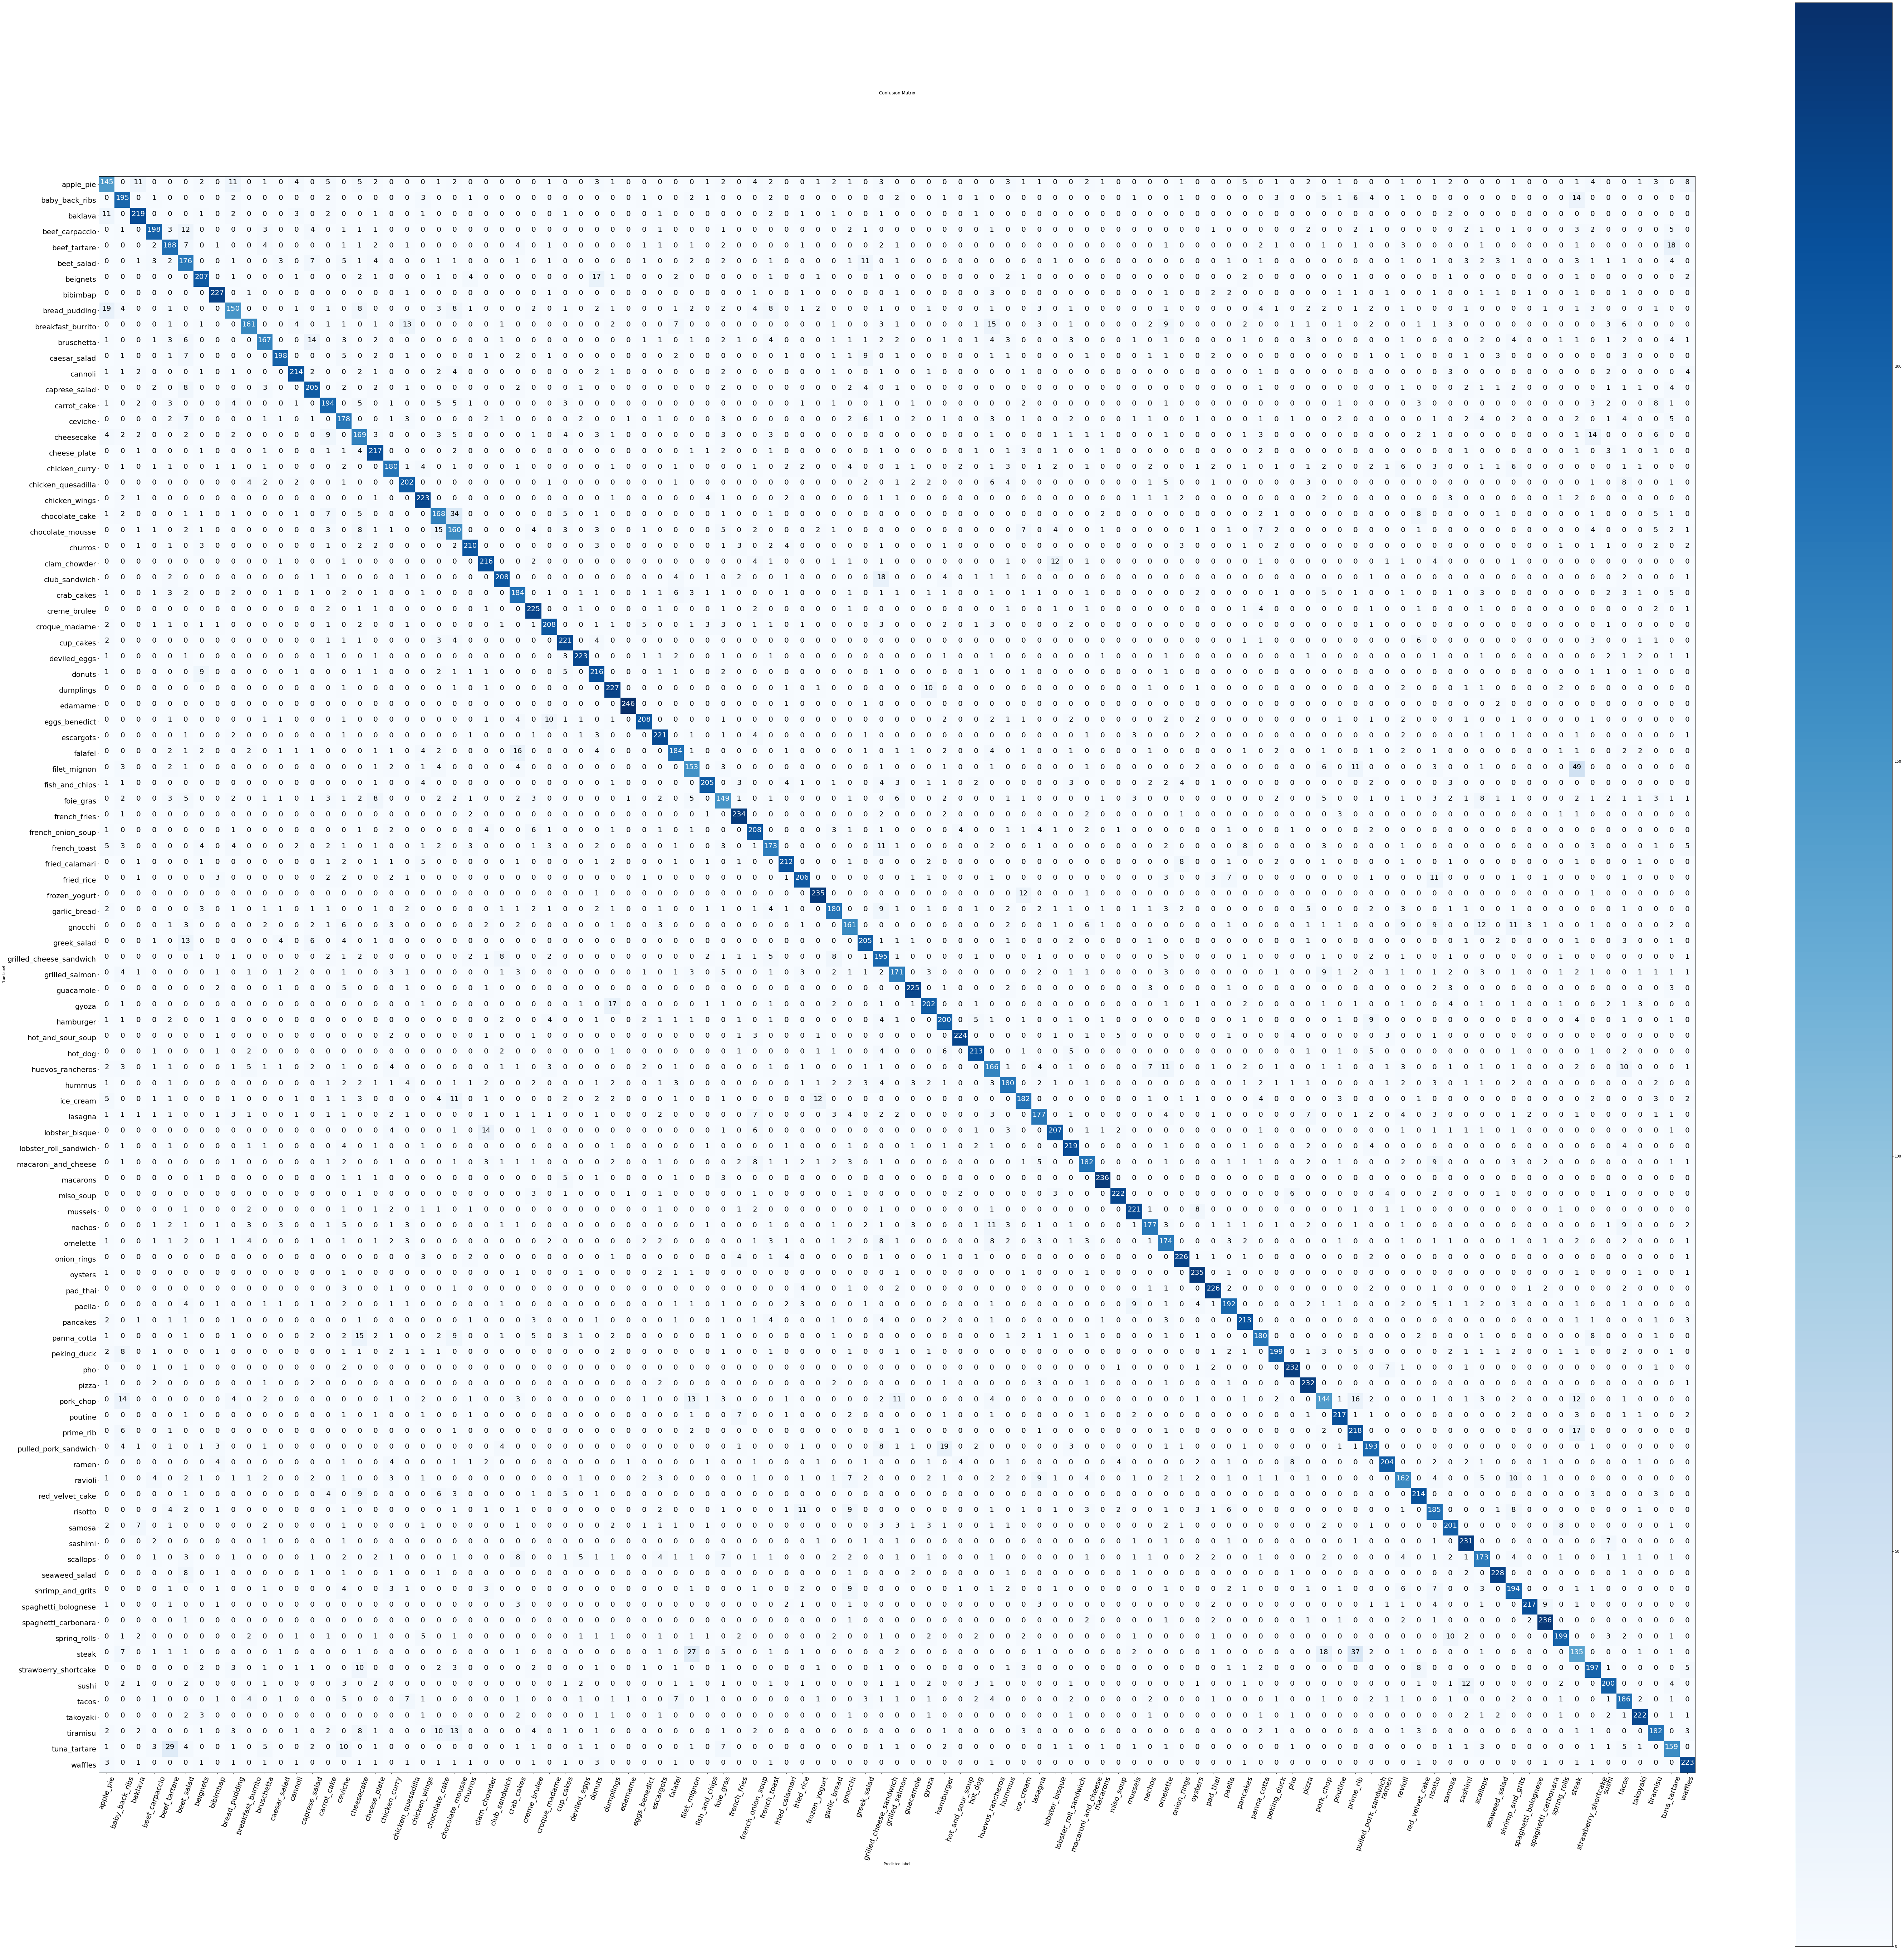

In [ ]:
make_confusion_matrix(y_true=y_labels, 
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

### Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.64      0.58      0.61       250
           1       0.71      0.78      0.75       250
           2       0.84      0.88      0.86       250
           3       0.85      0.79      0.82       250
           4       0.69      0.75      0.72       250
           5       0.60      0.70      0.65       250
           6       0.83      0.83      0.83       250
           7       0.89      0.91      0.90       250
           8       0.71      0.60      0.65       250
           9       0.83      0.64      0.73       250
          10       0.80      0.67      0.73       250
          11       0.90      0.79      0.84       250
          12       0.88      0.86      0.87       250
          13       0.79      0.82      0.80       250
          14       0.76      0.78      0.77       250
          15       0.61      0.71      0.66       250
          16       0.61      0.68      0.64       250
          17       0.78    

In [ ]:
# Get a dict of classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k,v in classification_report_dict.items():
  if k=="accuracy":
    break;
  else:
    # Add class names and f1_scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v['f1-score']

import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
33,edamame,0.982036
63,macarons,0.944000
91,spaghetti_carbonara,0.932806
54,hot_and_sour_soup,0.919918
45,frozen_yogurt,0.917969
...,...,...
77,pork_chop,0.614072
39,foie_gras,0.609407
0,apple_pie,0.607966
22,chocolate_mousse,0.602637


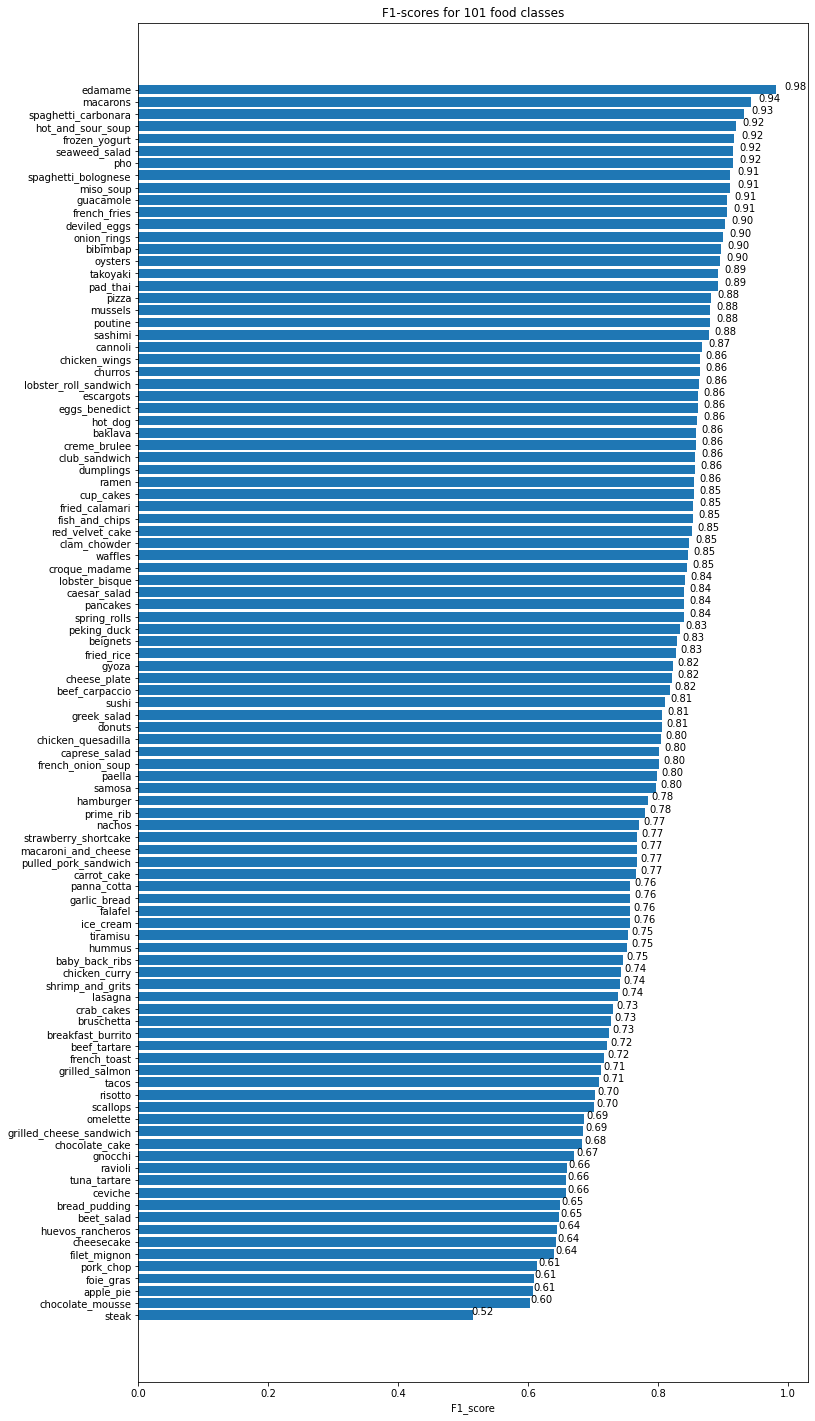

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_name'])
ax.set_xlabel('F1_score')
ax.set_title('F1-scores for 101 food classes')
ax.invert_yaxis();

def autolabel(rects):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')
    
autolabel(scores) 

### Find the most wrong prediction

In [ ]:
import pandas as pd
pred_df = pd.DataFrame({'y_true': y_labels,
                        'y_pred': pred_classes,
                        'pred_conf': preds_probs.max(axis=1),
                        'y_true_classname': [class_names[i] for i in y_labels],
                        'y_pred_classname': [class_names[i] for i in pred_classes]})
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,29,29,0.996304,cup_cakes,cup_cakes,True
1,81,81,0.999991,ramen,ramen,True
2,91,91,0.999994,spaghetti_carbonara,spaghetti_carbonara,True
3,53,53,0.998928,hamburger,hamburger,True
4,97,97,0.999398,takoyaki,takoyaki,True
...,...,...,...,...,...,...
25245,38,38,1.000000,fish_and_chips,fish_and_chips,True
25246,86,86,0.999995,sashimi,sashimi,True
25247,76,46,0.697391,pizza,garlic_bread,False
25248,31,31,1.000000,donuts,donuts,True


In [ ]:
top_100_wrong = pred_df[pred_df['pred_correct']==False].sort_values('pred_conf',ascending=False)[:100]
top_100_wrong

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
15437,56,66,1.000000,huevos_rancheros,nachos,False
9735,87,30,1.000000,scallops,deviled_eggs,False
900,14,29,1.000000,carrot_cake,cup_cakes,False
13884,46,10,1.000000,garlic_bread,bruschetta,False
7455,43,68,1.000000,fried_calamari,onion_rings,False
...,...,...,...,...,...,...
21257,30,29,0.999770,deviled_eggs,cup_cakes,False
6618,58,45,0.999755,ice_cream,frozen_yogurt,False
18490,22,60,0.999753,chocolate_mousse,lobster_bisque,False
21085,47,15,0.999752,gnocchi,ceviche,False
